# PHASE 1

In [1]:
from pyspark.sql.functions import *
from functools import reduce
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.pyplot import figure
import numpy as np
import math
from __future__ import division
%matplotlib inline

In [2]:
GDP_dataset = 'Spark_Dataset/GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290.csv'
HDI_dataset = 'Spark_Dataset/HDI/Human Development Index (HDI).csv'
Infant_Mortality_dataset = 'Spark_Dataset/Infant_Mortality_Rate/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276.csv'
Life_Expectancy_dataset = 'Spark_Dataset/Life_Expectancy/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296.csv'
Population_dataset = 'Spark_Dataset/Population/API_SP.POP.TOTL_DS2_en_csv_v2_10203548/API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv'

In [3]:
def developed_countries_list():
    dc_list = []
    dc_list.append("Australia")
    dc_list.append("Austria")
    dc_list.append("Belgium")
    dc_list.append("Canada")
    dc_list.append("Cyprus")
    dc_list.append("Czech Republic")
    dc_list.append("Denmark")
    dc_list.append("Finland")
    dc_list.append("France")
    dc_list.append("Germany")
    dc_list.append("Greece")
    #dc_list.append("Hong Kong SAR, China")
    dc_list.append("Iceland")
    dc_list.append("Ireland")
    dc_list.append("Israel")
    dc_list.append("Italy")
    dc_list.append("Japan")
    #dc_list.append("Korea, Rep.")
    dc_list.append("Luxembourg")
    dc_list.append("Malta")
    dc_list.append("Netherlands")
    dc_list.append("New Zealand")
    dc_list.append("Norway")
    dc_list.append("Portugal")
    dc_list.append("Singapore")
    dc_list.append("Slovak Republic")
    dc_list.append("Slovenia")
    dc_list.append("Spain")
    dc_list.append("Sweden")
    dc_list.append("Switzerland")
    #dc_list.append("Taiwan")
    dc_list.append("United Kingdom")
    dc_list.append("United States")
    return dc_list

In [4]:
def addColumnIndex(df): 
    oldColumns = df.schema.names
    newColumns = oldColumns + ["columnindex"]
    df_indexed = df.rdd.zipWithIndex().map(lambda (row, columnindex): \
                                         row + (columnindex,)).toDF(newColumns)   
    return df_indexed

In [5]:
gdp_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(GDP_dataset)
hdi_df = spark.read.option('header','true').option('inferSchema','true').csv(HDI_dataset)
im_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Infant_Mortality_dataset)
le_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Life_Expectancy_dataset)
pop_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Population_dataset)

In [6]:
hdi_drop_col = []
for i in range(3,len(hdi_df.schema.names)):
    if(i%2 == 1):
        hdi_drop_col.append(hdi_df.schema.names[i])
hdi_df = hdi_df.withColumn('Country', ltrim(hdi_df.Country))
hdi_df = hdi_df.select([column for column in hdi_df.columns if column not in hdi_drop_col])
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Czechia', 'Czech Republic'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Hong Kong, China (SAR)', 'Hong Kong SAR, China'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Korea (Republic of)', 'Korea, Rep.'))
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Slovakia', 'Slovak Republic'))

In [7]:
# Get the list of all developed countries   
countries_list = developed_countries_list()
# Add India among other countries for comparison and analysis
countries_list.append("India")

In [8]:
developed_gdp_df = gdp_df.filter(col('Country Name').isin(countries_list))
developed_im_df = im_df.filter(col('Country Name').isin(countries_list))
developed_le_df = le_df.filter(col('Country Name').isin(countries_list))
developed_hdi_df = hdi_df.filter(col('Country').isin(countries_list))
developed_pop_df = pop_df.filter(col('Country Name').isin(countries_list))

In [9]:
drop_cols_n = range(1960,1995)
drop_cols_n.append(2017)
drop_cols_s = [str(i) for i in drop_cols_n]

In [10]:
developed_pop_df = developed_pop_df.select([column for column in developed_pop_df.columns if column not in drop_cols_s])
developed_pop_df = developed_pop_df.select([column for column in developed_pop_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_pop_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_pop_df2 = developed_pop_df.select([c for c in developed_pop_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_pop_rdd = developed_pop_df2.rdd.map(tuple)

# Transpose Data
developed_pop_rddT1 = developed_pop_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_pop_rddT2 = developed_pop_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_pop_rddT3 = developed_pop_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_pop_rddT4 = developed_pop_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_pop_transposed_df = developed_pop_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_pop_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = 1000000000 #developed_pop_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_pop_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_pop_transposed_df = developed_pop_transposed_df.withColumn(name, col(name)/divider)

In [11]:
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in drop_cols_s])
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_gdp_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_gdp_df2 = developed_gdp_df.select([c for c in developed_gdp_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_gdp_rdd = developed_gdp_df2.rdd.map(tuple)

# Transpose Data
developed_gdp_rddT1 = developed_gdp_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_gdp_rddT2 = developed_gdp_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_gdp_rddT3 = developed_gdp_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_gdp_rddT4 = developed_gdp_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_gdp_transposed_df = developed_gdp_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_gdp_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = 1000000000 #developed_gdp_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_gdp_transposed_df = developed_gdp_transposed_df.withColumn(name, col(name)/divider)

In [12]:
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in drop_cols_s])
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_im_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_im_df2 = developed_im_df.select([c for c in developed_im_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_im_rdd = developed_im_df2.rdd.map(tuple)

# Transpose Data
developed_im_rddT1 = developed_im_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_im_rddT2 = developed_im_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_im_rddT3 = developed_im_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_im_rddT4 = developed_im_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_im_transposed_df = developed_im_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_im_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_im_transposed_df.agg({name: "max"}).collect()[0][0]
#        #developed_im_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_im_transposed_df = developed_im_transposed_df.withColumn(name, col(name)/divider)

In [13]:
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in drop_cols_s])
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_le_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_le_df2 = developed_le_df.select([c for c in developed_le_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_le_rdd = developed_le_df2.rdd.map(tuple)

# Transpose Data
developed_le_rddT1 = developed_le_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_le_rddT2 = developed_le_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_le_rddT3 = developed_le_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_le_rddT4 = developed_le_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_le_transposed_df = developed_le_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_le_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_le_transposed_df.agg({name: "max"}).collect()[0][0]
#        #developed_le_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_le_transposed_df = developed_le_transposed_df.withColumn(name, col(name)/divider)

In [14]:
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in drop_cols_s])
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in ['HDI Rank (2017)']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_hdi_df.select("Country").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_hdi_df2 = developed_hdi_df.select([c for c in developed_hdi_df.columns if c not in ['Country']])

# Convert DataFrame to RDD
developed_hdi_rdd = developed_hdi_df2.rdd.map(tuple)

# Transpose Data
developed_hdi_rddT1 = developed_hdi_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_hdi_rddT2 = developed_hdi_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_hdi_rddT3 = developed_hdi_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_hdi_rddT4 = developed_hdi_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_hdi_transposed_df = developed_hdi_rddT4.toDF(new_header)
#developed_hdi_transposed_df.show()

#Normalize the columns
#for field in developed_hdi_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_hdi_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_hdi_transposed_df = developed_hdi_transposed_df.withColumn(name, col(name)/divider)

In [15]:
final_pop_pd_df = developed_pop_transposed_df.toPandas()
final_pop_pd_df.index = range(1995,2017)

final_gdp_pd_df = developed_gdp_transposed_df.toPandas()
final_gdp_pd_df.index = range(1995,2017)

final_im_pd_df_ni = developed_im_transposed_df.toPandas()
final_im_pd_df_ni.index = range(1995,2017)
final_im_pd_df = np.power(final_im_pd_df_ni,-1) 

final_le_pd_df = developed_le_transposed_df.toPandas()
final_le_pd_df.index = range(1995,2017)

final_hdi_pd_df = developed_hdi_transposed_df.toPandas()
final_hdi_pd_df.index = range(1995,2017)

In [16]:
final_gdp_perc_pd_df = pd.DataFrame().reindex_like(final_gdp_pd_df)
for i in range(0,final_gdp_perc_pd_df.shape[0]):
    i = i+1995
    for j in range(0,final_gdp_perc_pd_df.columns.shape[0]):
        gdp_val = final_gdp_pd_df.loc[i, final_gdp_pd_df.columns[j]]
        pop_val = final_pop_pd_df.loc[i, final_pop_pd_df.columns[j]]
        final_gdp_perc_pd_df.loc[i, final_gdp_perc_pd_df.columns[j]] = gdp_val/pop_val

In [17]:
gdp_pc_factor = 0.0001
im_factor = 1
le_factor = 1
hdi_factor = 10

In [18]:
final_pd_dfs = [gdp_pc_factor*final_gdp_perc_pd_df,im_factor*final_im_pd_df,le_factor*final_le_pd_df,hdi_factor*final_hdi_pd_df]
final_df = reduce(lambda x, y: x.add(y, fill_value=0), final_pd_dfs)

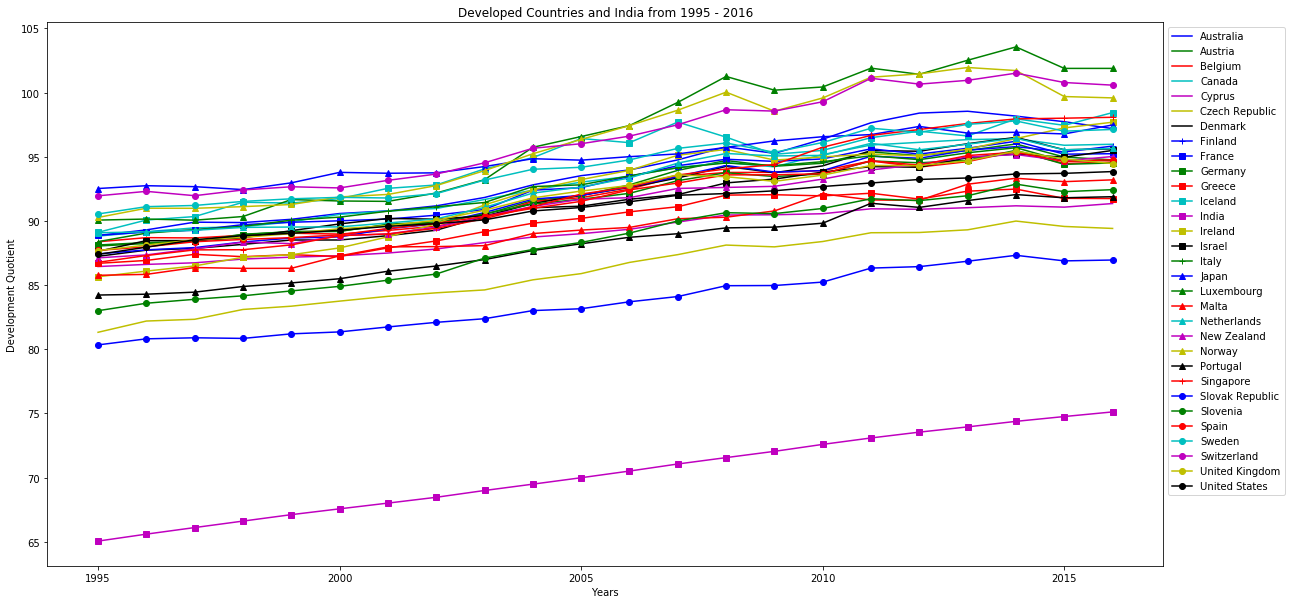

In [19]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax1 = final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset)
ax1.legend(bbox_to_anchor=(1, 1))
ax1.set_xlabel("Years")
ax1.set_ylabel("Development Quotient")

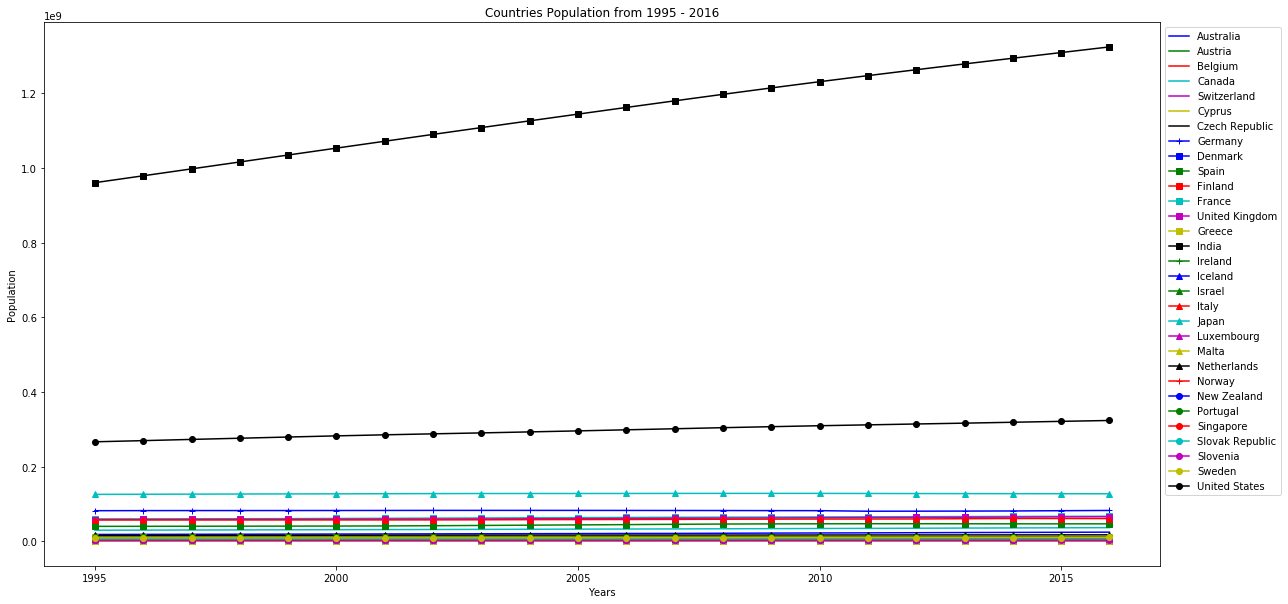

In [20]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax5 = final_pop_pd_df.plot(title="Countries Population from 1995 - 2016",figsize=(20,10),style=colorset)
ax5.legend(bbox_to_anchor=(1, 1))
ax5.set_xlabel("Years")
ax5.set_ylabel("Population")

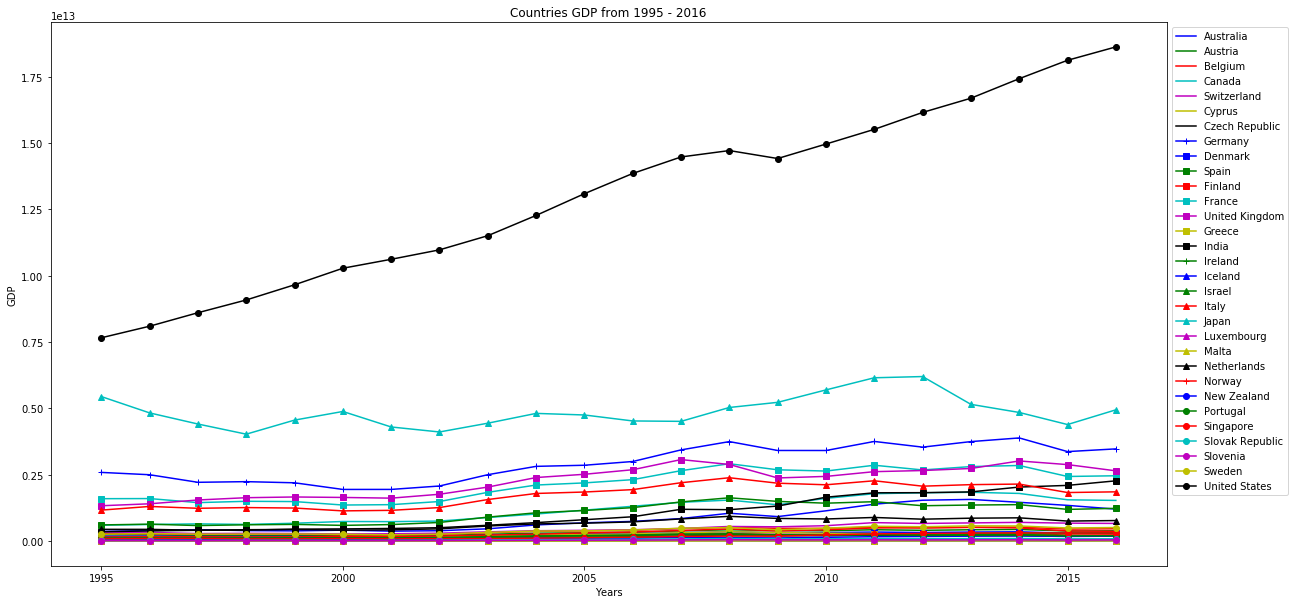

In [21]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax6 = final_gdp_pd_df.plot(title="Countries GDP from 1995 - 2016",figsize=(20,10),style=colorset)
ax6.legend(bbox_to_anchor=(1, 1))
ax6.set_xlabel("Years")
ax6.set_ylabel("GDP")

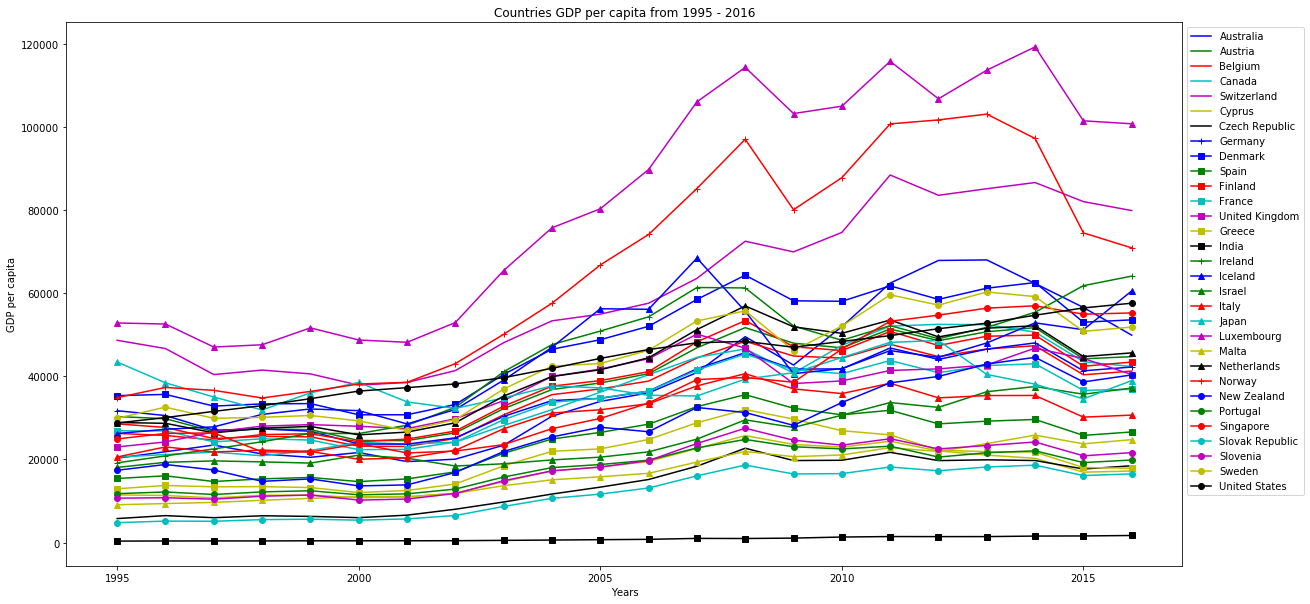

In [22]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax2 = final_gdp_perc_pd_df.plot(title="Countries GDP per capita from 1995 - 2016",figsize=(20,10),style=colorset)
ax2.legend(bbox_to_anchor=(1, 1))
ax2.set_xlabel("Years")
ax2.set_ylabel("GDP per capita")

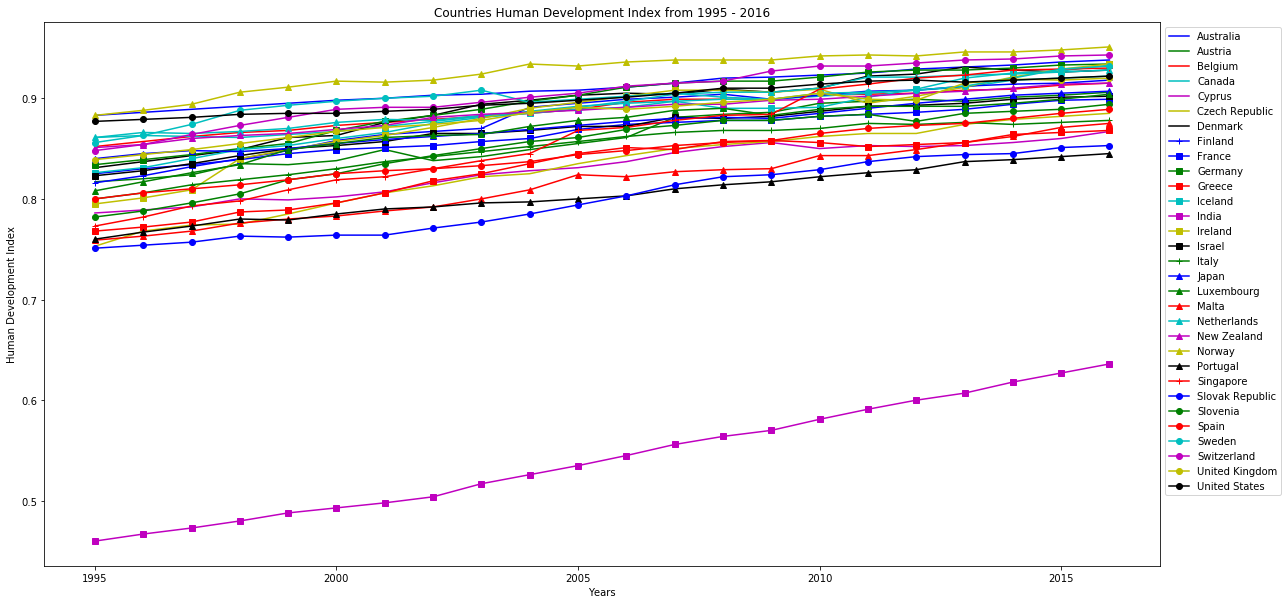

In [23]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax0 = final_hdi_pd_df.plot(title="Countries Human Development Index from 1995 - 2016",figsize=(20,10),style=colorset)
ax0.legend(bbox_to_anchor=(1, 1))
ax0.set_xlabel("Years")
ax0.set_ylabel("Human Development Index")

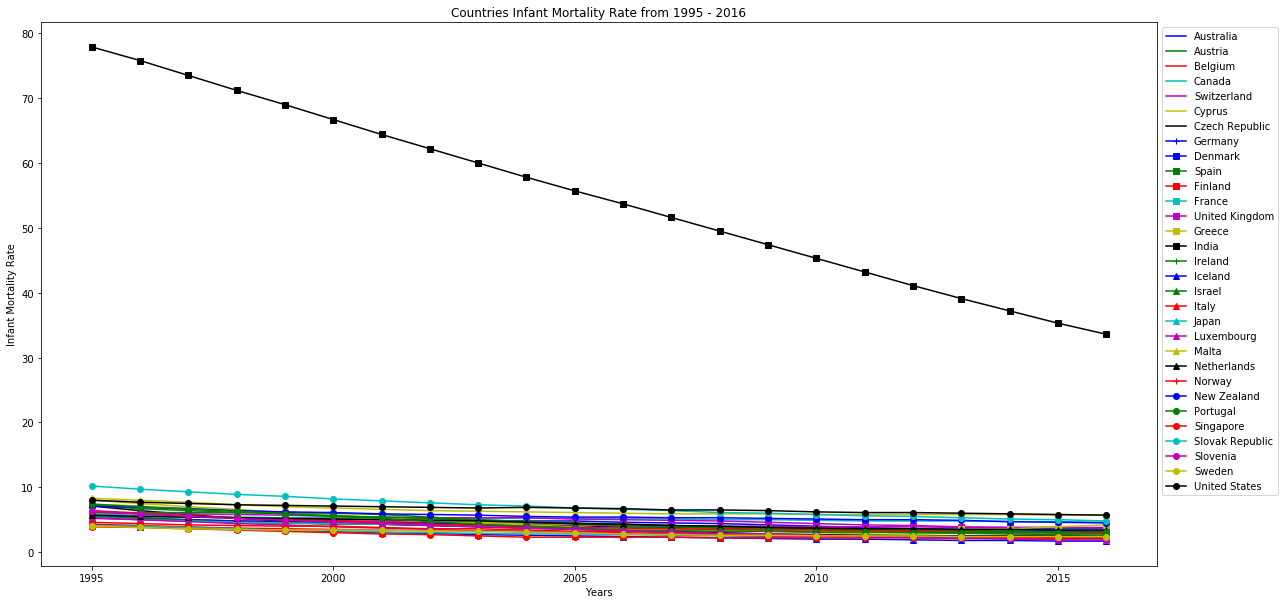

In [24]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax3 = final_im_pd_df_ni.plot(title="Countries Infant Mortality Rate from 1995 - 2016",figsize=(20,10),style=colorset)
ax3.legend(bbox_to_anchor=(1, 1))
ax3.set_xlabel("Years")
ax3.set_ylabel("Infant Mortality Rate")

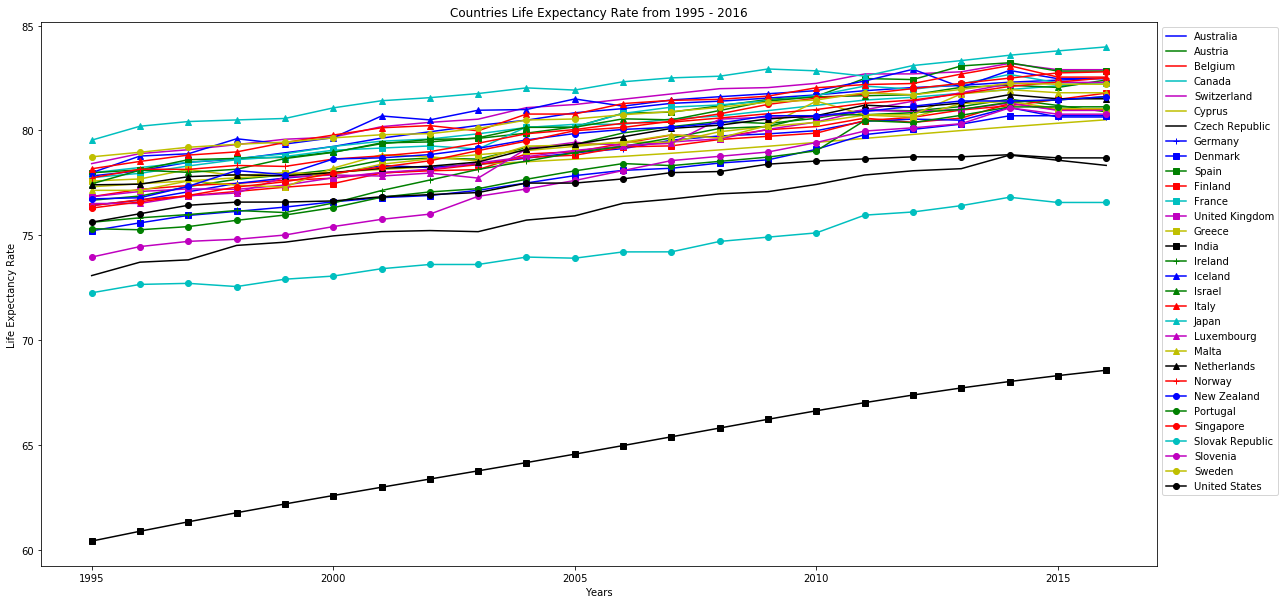

In [25]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax4 = final_le_pd_df.plot(title="Countries Life Expectancy Rate from 1995 - 2016",figsize=(20,10),style=colorset)
ax4.legend(bbox_to_anchor=(1, 1))
ax4.set_xlabel("Years")
ax4.set_ylabel("Life Expectancy Rate")

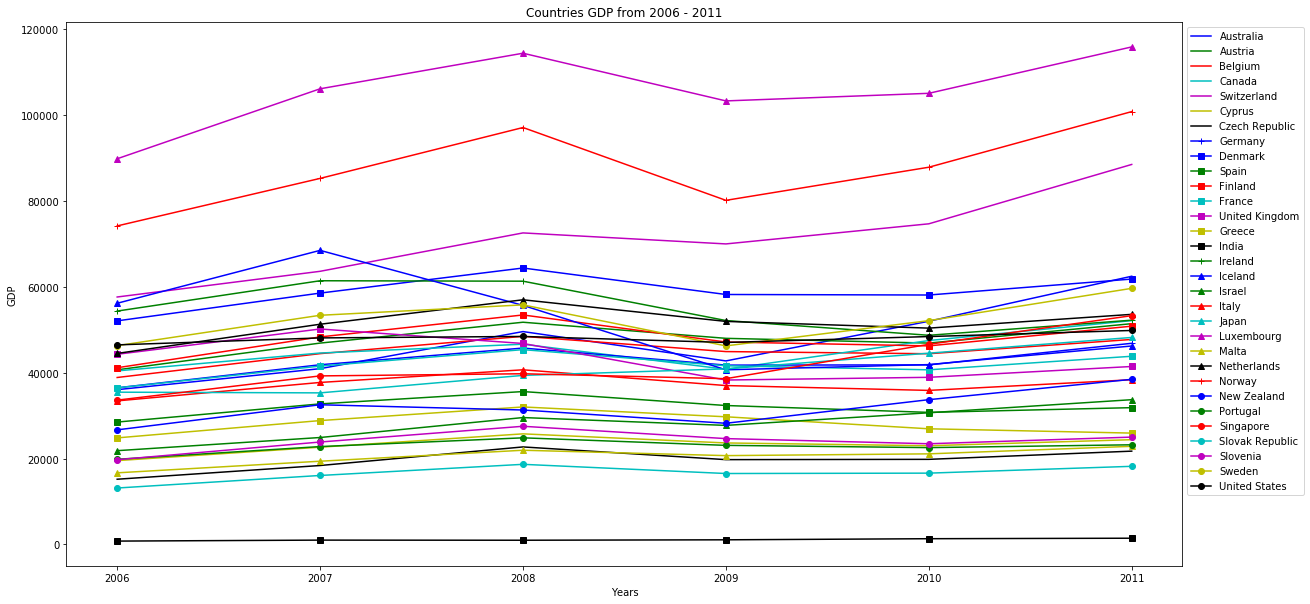

In [26]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax7 = final_gdp_perc_pd_df[11:17].plot(title="Countries GDP from 2006 - 2011",figsize=(20,10),style=colorset)
ax7.legend(bbox_to_anchor=(1, 1))
ax7.set_xlabel("Years")
ax7.set_ylabel("GDP")

# PHASE 2

TODO:

Planning to build models only for India with the dataset of India

1. Make a prediction model for GDP, Population, IMR, HDI, LER<br>
    1.1 Prediction Model for GDP<br>
    1.2 Prediction Model for Population<br>
    1.3 Prediction Model for IMR<br>
    1.4 Prediction Model for HDI<br>
    1.5 Prediction Model for LER<br><br>
    
2. Find the total development quotient

1.1 Prediction Model for GDP<br>

1. Military expenditure (% of central government expenditure) (MS.MIL.XPND.ZS)
2. Armed forces personnel, total (MS.MIL.TOTL.P1)
3. Foreign direct investment, net outflows (% of GDP) (BM.KLT.DINV.WD.GD.ZS)
4. Trade in services (% of GDP) (BG.GSR.NFSV.GD.ZS)
5. Merchandise exports (current US) (TX.VAL.MRCH.CD.WT)
6. Agricultural land (% of land area) (AG.LND.AGRI.ZS)
7. Trade (% of GDP) (NE.TRD.GNFS.ZS)
8. Exports of goods and services (% of GDP) (NE.EXP.GNFS.ZS)
9. Imports of goods and services (% of GDP) (NE.IMP.GNFS.ZS)
10. Gross national expenditure (% of GDP) (NE.DAB.TOTL.ZS)
11. Foreign direct investment, net inflows (% of GDP) (BX.KLT.DINV.WD.GD.ZS)
12. Urban population (% of total) (SP.URB.TOTL.IN.ZS)
13. Population growth (annual %) (SP.POP.GROW)
14. School enrollment, primary (% net) (SE.PRM.NENR.MA)
15. Pupil-teacher ratio, primary (SE.PRM.ENRL.TC.ZS)
16. Primary completion rate, total (SE.PRM.CMPT.ZS)
17. Literacy rate, adult total (% of people ages 15 and above) (SE.ADT.LITR.ZS)
18. Unemployment, total (% of total labor force) (modeled ILO estimate) (SL.UEM.TOTL.ZS)
19. Labor force, total (SL.TLF.TOTL.IN)
20. Inflation, consumer prices (annual %) (FP.CPI.TOTL.ZG)
21. Services, value added (% of GDP) (NV.SRV.TOTL.ZS)
22. Agriculture, forestry, and fishing, value added (% of GDP) (NV.AGR.TOTL.ZS)

In [27]:
def first_NAN_dffill(df):
    final_dataf = df
    start_flag = 0
    start = 0
    start_i = 0
    end = 0
    end_i = 0
    for i in range(0,final_dataf.shape[0]):
        if(not(math.isnan(final_dataf[i]))):
            if(start_flag == 0):
                start_flag = 1
                start = final_dataf[i]
                start_i = i
            else:
                end = final_dataf[i]
                end_i = i
    jump = ((end-start)/(end_i-start_i))
    num = start
    #print(start_i)
    for i in reversed(range(0,start_i)):
        final_dataf[i] = num - jump
        num = final_dataf[i]
    return final_dataf

In [28]:
def last_NAN_dffill(df):
    final_dataf = df
    start_flag = 0
    start = 0
    start_i = 0
    end = 0
    end_i = 0
    for i in range(0,final_dataf.shape[0]):
        if(not(math.isnan(final_dataf[i]))):
            if(start_flag == 0):
                start_flag = 1
                start = final_dataf[i]
                start_i = i
            else:
                end = final_dataf[i]
                end_i = i
    jump = ((end-start)/(end_i-start_i))
    num = end
    for i in range(end_i+1,final_dataf.shape[0]):
        final_dataf[i] = num + jump
        num = final_dataf[i]
    return final_dataf

In [29]:
def first_not_NAN_dffill(df):
    final_dataf = df
    start_flag = 0
    start = 0
    start_i = 0
    end = 0
    end_i = 0
    for i in range(0,final_dataf.shape[0]):
        if((start_flag==0)&(math.isnan(final_dataf[i]))):
            start_flag = 1
            start_i = i-1
            start = final_dataf[i-1]
        if((start_flag == 1)&(not(math.isnan(final_dataf[i])))):
            start_flag=0
            end = final_dataf[i]
            end_i = i
            jump = ((end-start)/(end_i-start_i))
            num = start
            for x in range(start_i+1,end_i):
                final_dataf[x] = num + jump
                num = final_dataf[x]
    return final_dataf

In [30]:
India_dataset = 'Spark_Dataset/India_Data/API_IND_DS2_en_csv_v2_10135894/API_IND_DS2_en_csv_v2_10135894.csv'

india_sp_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(India_dataset)
india_df = india_sp_df.toPandas()

In [31]:
Australia_dataset = 'Spark_Dataset/Countries/API_AUS_DS2_en_csv_v2_10225825/API_AUS_DS2_en_csv_v2_10225825.csv'
Austria_dataset = 'Spark_Dataset/Countries/API_AUT_DS2_en_csv_v2_10225948/API_AUT_DS2_en_csv_v2_10225948.csv'
Belgium_dataset = 'Spark_Dataset/Countries/API_BEL_DS2_en_csv_v2_10230074/API_BEL_DS2_en_csv_v2_10230074.csv'
Canada_dataset = 'Spark_Dataset/Countries/API_BEL_DS2_en_csv_v2_10230074/API_BEL_DS2_en_csv_v2_10230074.csv'
Cyprus_dataset = 'Spark_Dataset/Countries/API_CYP_DS2_en_csv_v2_10225877/API_CYP_DS2_en_csv_v2_10225877.csv'
Czech_Republic_dataset = 'Spark_Dataset/Countries/API_CZE_DS2_en_csv_v2_10225980/API_CZE_DS2_en_csv_v2_10225980.csv'
Denmark_dataset = 'Spark_Dataset/Countries/API_DNK_DS2_en_csv_v2_10228191/API_DNK_DS2_en_csv_v2_10228191.csv'
Finland_dataset = 'Spark_Dataset/Countries/API_FIN_DS2_en_csv_v2_10230084/API_FIN_DS2_en_csv_v2_10230084.csv'
France_dataset = 'Spark_Dataset/Countries/API_FRA_DS2_en_csv_v2_10225972/API_FRA_DS2_en_csv_v2_10225972.csv'
Germany_dataset = 'Spark_Dataset/Countries/API_DEU_DS2_en_csv_v2_10226025/API_DEU_DS2_en_csv_v2_10226025.csv'
Greece_dataset = 'Spark_Dataset/Countries/API_GRC_DS2_en_csv_v2_10225835/API_GRC_DS2_en_csv_v2_10225835.csv'
Iceland_dataset = 'Spark_Dataset/Countries/API_ISL_DS2_en_csv_v2_10226198/API_ISL_DS2_en_csv_v2_10226198.csv'
Ireland_dataset = 'Spark_Dataset/Countries/API_IRL_DS2_en_csv_v2_10226030/API_IRL_DS2_en_csv_v2_10226030.csv'
Israel_dataset = 'Spark_Dataset/Countries/API_ISR_DS2_en_csv_v2_10224712/API_ISR_DS2_en_csv_v2_10224712.csv'
Italy_dataset = 'Spark_Dataset/Countries/API_ITA_DS2_en_csv_v2_10225789/API_ITA_DS2_en_csv_v2_10225789.csv'
Japan_dataset = 'Spark_Dataset/Countries/API_JPN_DS2_en_csv_v2_10228700/API_JPN_DS2_en_csv_v2_10228700.csv'
Luxembourg_dataset = 'Spark_Dataset/Countries/API_LUX_DS2_en_csv_v2_10227335/API_LUX_DS2_en_csv_v2_10227335.csv'
Malta_dataset = 'Spark_Dataset/Countries/API_MLT_DS2_en_csv_v2_10225983/API_MLT_DS2_en_csv_v2_10225983.csv'
Netherlands_dataset = 'Spark_Dataset/Countries/API_NLD_DS2_en_csv_v2_10226049/API_NLD_DS2_en_csv_v2_10226049.csv'
New_Zealand_dataset = 'Spark_Dataset/Countries/API_NZL_DS2_en_csv_v2_10225977/API_NZL_DS2_en_csv_v2_10225977.csv'
Norway_dataset = 'Spark_Dataset/Countries/API_NOR_DS2_en_csv_v2_10228479/API_NOR_DS2_en_csv_v2_10228479.csv'
Portugal_dataset = 'Spark_Dataset/Countries/API_PRT_DS2_en_csv_v2_10230142/API_PRT_DS2_en_csv_v2_10230142.csv'
Singapore_dataset = 'Spark_Dataset/Countries/API_SGP_DS2_en_csv_v2_10225854/API_SGP_DS2_en_csv_v2_10225854.csv'
Slovak_Republic_dataset = 'Spark_Dataset/Countries/API_SVK_DS2_en_csv_v2_10226074/API_SVK_DS2_en_csv_v2_10226074.csv'
Slovenia_dataset = 'Spark_Dataset/Countries/API_SVN_DS2_en_csv_v2_10229797/API_SVN_DS2_en_csv_v2_10229797.csv'
Spain_dataset = 'Spark_Dataset/Countries/API_ESP_DS2_en_csv_v2_10226202/API_ESP_DS2_en_csv_v2_10226202.csv'
Sweden_dataset = 'Spark_Dataset/Countries/API_SWE_DS2_en_csv_v2_10225009/API_SWE_DS2_en_csv_v2_10225009.csv'
Switzerland_dataset = 'Spark_Dataset/Countries/API_CHE_DS2_en_csv_v2_10226455/API_CHE_DS2_en_csv_v2_10226455.csv'
United_Kingdom_dataset = 'Spark_Dataset/Countries/API_GBR_DS2_en_csv_v2_10229553/API_GBR_DS2_en_csv_v2_10229553.csv'
United_States_dataset = 'Spark_Dataset/Countries/API_USA_DS2_en_csv_v2_10225922/API_USA_DS2_en_csv_v2_10225922.csv'

countries_dataset = []
countries_dataset.append(Australia_dataset)
countries_dataset.append(Austria_dataset)
countries_dataset.append(Belgium_dataset)
countries_dataset.append(Canada_dataset)
countries_dataset.append(Cyprus_dataset)
countries_dataset.append(Czech_Republic_dataset)
countries_dataset.append(Denmark_dataset)
countries_dataset.append(Finland_dataset)
countries_dataset.append(France_dataset)
countries_dataset.append(Germany_dataset)
countries_dataset.append(Greece_dataset)
countries_dataset.append(Iceland_dataset)
countries_dataset.append(Ireland_dataset)
countries_dataset.append(Israel_dataset)
countries_dataset.append(Italy_dataset)
countries_dataset.append(Japan_dataset)
countries_dataset.append(Malta_dataset)
countries_dataset.append(Luxembourg_dataset)
countries_dataset.append(Netherlands_dataset)
countries_dataset.append(New_Zealand_dataset)
countries_dataset.append(Norway_dataset)
countries_dataset.append(Portugal_dataset)
countries_dataset.append(Singapore_dataset)
countries_dataset.append(Slovak_Republic_dataset)
countries_dataset.append(Slovenia_dataset)
countries_dataset.append(Spain_dataset)
countries_dataset.append(Sweden_dataset)
countries_dataset.append(Switzerland_dataset)
countries_dataset.append(United_Kingdom_dataset)
countries_dataset.append(United_States_dataset)

countries_df_list = []
for i in range(0,len(countries_dataset)):
    countries_df_i = spark.read.option('header','true').option('sep', ',').option('inferSchema','true').csv(countries_dataset[i])
    countries_df_list.append(countries_df_i.toPandas())

In [32]:
dev_ind_list = []
dev_ind_list.append('MS.MIL.XPND.ZS')
dev_ind_list.append('MS.MIL.TOTL.P1')
dev_ind_list.append('BM.KLT.DINV.WD.GD.ZS')
dev_ind_list.append('BG.GSR.NFSV.GD.ZS')
dev_ind_list.append('TX.VAL.MRCH.CD.WT')
dev_ind_list.append('NE.TRD.GNFS.ZS')
dev_ind_list.append('NE.EXP.GNFS.ZS')
dev_ind_list.append('NE.IMP.GNFS.ZS')
dev_ind_list.append('NE.DAB.TOTL.ZS')
dev_ind_list.append('BX.KLT.DINV.WD.GD.ZS')
dev_ind_list.append('SP.URB.TOTL.IN.ZS')
dev_ind_list.append('SP.POP.GROW')
#dev_ind_list.append('SE.PRM.NENR.MA')
dev_ind_list.append('SE.PRM.ENRL.TC.ZS')
#dev_ind_list.append('SE.PRM.CMPT.ZS')
#dev_ind_list.append('SE.ADT.LITR.ZS')
dev_ind_list.append('SL.UEM.TOTL.ZS')
dev_ind_list.append('SL.TLF.TOTL.IN')
dev_ind_list.append('FP.CPI.TOTL.ZG')
dev_ind_list.append('NV.SRV.TOTL.ZS')
dev_ind_list.append('NV.AGR.TOTL.ZS')
dev_ind_list.append('AG.LND.AGRI.ZS')

In [33]:
merch_exp_div = 100000
labor_force_div = 10000
arm_force_per_div = 1000

In [34]:
india_df_fil = india_df[india_df['Indicator Code'].isin(dev_ind_list)]
india_df_fil = india_df_fil.drop(drop_cols_s,axis=1)
india_df_fil = india_df_fil.drop(['Country Name','Country Code','Indicator Name'],axis=1)
india_df_fil = india_df_fil.set_index('Indicator Code')
india_df_final = india_df_fil.T
#india_df_fil = india_df_fil.dropna()
#india_df_final.isnull().sum()

india_df_final['TX.VAL.MRCH.CD.WT'] = india_df_final['TX.VAL.MRCH.CD.WT']/merch_exp_div
india_df_final['SL.TLF.TOTL.IN'] = india_df_final['SL.TLF.TOTL.IN']/labor_force_div
india_df_final['MS.MIL.TOTL.P1'] = india_df_final['MS.MIL.TOTL.P1']/arm_force_per_div

In [35]:
countries_df_final_list = []
for i in range(0,len(countries_df_list)):
    countries_df_i = countries_df_list[i]
    countries_df_i_fil = countries_df_i[countries_df_i['Indicator Code'].isin(dev_ind_list)]
    countries_df_i_fil = countries_df_i_fil.drop(drop_cols_s,axis=1)
    countries_df_i_fil = countries_df_i_fil.drop(['Country Name','Country Code','Indicator Name'],axis=1)
    countries_df_i_fil = countries_df_i_fil.set_index('Indicator Code')
    countries_df_i_final = countries_df_i_fil.T
    
    countries_df_i_final['TX.VAL.MRCH.CD.WT'] = countries_df_i_final['TX.VAL.MRCH.CD.WT']/merch_exp_div
    countries_df_i_final['SL.TLF.TOTL.IN'] = countries_df_i_final['SL.TLF.TOTL.IN']/labor_force_div
    countries_df_i_final['MS.MIL.TOTL.P1'] = countries_df_i_final['MS.MIL.TOTL.P1']/arm_force_per_div
    countries_df_final_list.append(countries_df_i_final)

In [36]:
for col in india_df_final.columns:
    if(india_df_final[col].isnull().values.any()):
        df_p = india_df_final[col]
        #print(df_p)
        if(math.isnan(df_p[0])):
            #print(india_df_final[col])
            india_df_final[col] = first_NAN_dffill(df_p)
            #print(india_df_final[col])
        india_df_final[col] = first_not_NAN_dffill(df_p)
        if(math.isnan(df_p[df_p.shape[0]-1])):
            india_df_final[col] = last_NAN_dffill(df_p)

In [37]:
for i in range(0,len(countries_df_final_list)):
    country_df_final = countries_df_final_list[i]
    for col in country_df_final.columns:
        if(country_df_final[col].isnull().values.any()):
            df_p = country_df_final[col]
            #print(df_p)
            if(math.isnan(df_p[0])):
                #print(india_df_final[col])
                country_df_final[col] = first_NAN_dffill(df_p)
                #print(india_df_final[col])
            country_df_final[col] = first_not_NAN_dffill(df_p)
            if(math.isnan(df_p[df_p.shape[0]-1])):
                country_df_final[col] = last_NAN_dffill(df_p)

In [38]:
def plot_corr(df,size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

In [39]:
def get_top_abs_correlations(df, col_name, min_corr=0.4):
    au_corr = df.corr().abs().unstack()
    au_corr_fil = au_corr[col_name]
    au_corr_fil_sorted = au_corr_fil.sort_values(kind="quicksort",ascending=False)
    return au_corr_fil_sorted[au_corr_fil_sorted>min_corr].index.astype('str')

Train GDP Models

In [40]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [41]:
gdp_india = final_gdp_perc_pd_df[['India']]
gdp_india.index = gdp_india.index.map(unicode) 
gdp_india = gdp_india.rename(index=str, columns={"India": "GDP.PC"})
gdp_f = pd.concat([india_df_final, gdp_india], axis=1)

In [42]:
countries_list = developed_countries_list()
gdp_country_list = []
for i in range(0,len(countries_df_final_list)):
    gdp_country = final_gdp_perc_pd_df[[countries_list[i]]]
    gdp_country.index = gdp_country.index.map(unicode)
    gdp_country = gdp_country.rename(index=str, columns={countries_list[i]: "GDP.PC"})
    gdp_country_list.append(pd.concat([countries_df_final_list[i], gdp_country], axis=1))

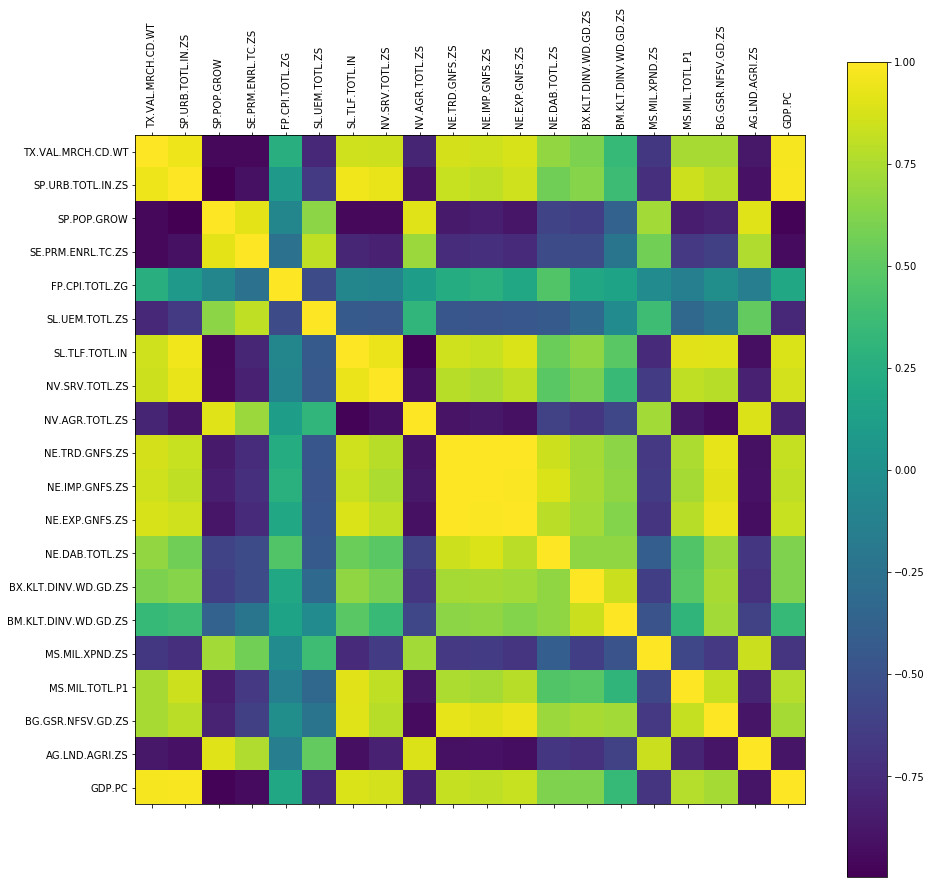

In [43]:
plot_corr(gdp_f)

In [44]:
gdp_flist = get_top_abs_correlations(gdp_f,'GDP.PC',0.4)

In [45]:
gdp_india_final_df = pd.DataFrame(gdp_f, columns=gdp_flist)

In [46]:
gdp_country_final_df = []
for i in range(0,len(gdp_country_list)):
    gdp_country_final_df.append(pd.DataFrame(gdp_country_list[i], columns=gdp_flist))

In [47]:
gdp_x_val_list = []
gdp_y_val_list = []
for row in gdp_india_final_df.iterrows():
    index, data = row
    gdp_y_val_list.append(data[0])
    gdp_x_val_list.append(data[1:].tolist())

In [48]:
for i in range(0,len(gdp_country_final_df)):
    gdp_df_i = gdp_country_final_df[i]
    for row in gdp_df_i.iterrows():
        index, data = row
        gdp_y_val_list.append(data[0])
        gdp_x_val_list.append(data[1:].tolist())

In [49]:
gdp_x_val_array = np.asarray(gdp_x_val_list)
gdp_y_val_array = np.asarray(gdp_y_val_list)

In [50]:
gdp_x_y_values_db = {} 
gdp_x_y_values_db['x_val'] = gdp_x_val_array 
gdp_x_y_values_db['y_val'] = gdp_y_val_array 

In [51]:
# Its important to use binary mode 
gdp_dbfile = open('gdp_x_y_countries_pickle', 'ab') 
# source, destination 
pickle.dump(gdp_x_y_values_db, gdp_dbfile)                      
gdp_dbfile.close() 

In [52]:
gdp_forest_model = RandomForestRegressor(random_state=21)
gdp_train_X, gdp_test_X, gdp_train_y, gdp_test_y = train_test_split(gdp_x_val_array, gdp_y_val_array, test_size=0.25, random_state=21)
gdp_rmse= np.sqrt(np.mean(-cross_val_score(gdp_forest_model, gdp_train_X, gdp_train_y,cv=5,  scoring='neg_mean_squared_error')))
print("RMSE : %f" % (gdp_rmse))
gdp_r2_score1= np.mean(cross_val_score(gdp_forest_model, gdp_train_X, gdp_train_y,cv=5,  scoring='r2'))
print("R2 score: %s" % '{:.2}'.format(gdp_r2_score1))

/Users/siddhant/miniconda/envs/dataScience_env/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE : 7157.182193
R2 score: 0.89


In [53]:
number_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': number_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [54]:
gdp_randomForestRegressor_dbfile = open('gdp_randomForestRegressor_pickle', 'rb')      
gdp_randomForestRegressor_db = pickle.load(gdp_randomForestRegressor_dbfile) 
#print x_y_values_db['x_val']
gdp_forest_model = gdp_randomForestRegressor_db['forest_model']
gdp_rf_random = gdp_randomForestRegressor_db['rf_random']
gdp_rf_grid = gdp_randomForestRegressor_db['rf_grid']
gdp_rf_cv_random = gdp_randomForestRegressor_db['rf_cv_random']
gdp_predictions = gdp_randomForestRegressor_db['predictions']
gdp_rmse3 = gdp_randomForestRegressor_db['rmse3']
gdp_r23 = gdp_randomForestRegressor_db['r23']
gdp_randomForestRegressor_dbfile.close() 

In [55]:
#forest_model = RandomForestRegressor(random_state=21)
#rf_random = RandomizedSearchCV(estimator = forest_model, param_distributions = random_grid, 
#                          cv = 5, n_jobs = -1,n_iter = 100, verbose = 0)
#rf_random.fit(train_X, train_y)
print(gdp_rf_random.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 40}


In [56]:
#param_grid = {'max_depth': [10, 20, 40, 60, 80],
#              'max_features': ['sqrt'],
#              'min_samples_leaf': [1, 3, 4, 5],
#              'min_samples_split': [2, 4, 8],
#              'n_estimators': [100, 300, 600, 1000],
#             'bootstrap': [False, True]}
# Create a basic model
#rf = RandomForestRegressor(random_state=21)
# Instantiate the grid search model
#rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 0)
#rf_grid.fit(train_X, train_y)
print(gdp_rf_grid.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 20}


In [57]:
#rf_cv_random=RandomForestRegressor(random_state=21,n_estimators= 300, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 20, bootstrap= False)
#rf_cv_random.fit(train_X,train_y )
#predictions=rf_cv_random.predict(test_X)
#rmse3 = np.sqrt(mean_squared_error(test_y, predictions))
print("RMSE : %f" % (gdp_rmse3))
#r23= r2_score(test_y,predictions)
print("R2 score: %s" % '{:.2}'.format(gdp_r23))

RMSE : 4350.315154
R2 score: 0.94


In [58]:
gdp_errors = math.fabs(np.mean(gdp_predictions/gdp_test_y - 1))
gdp_mape = 100 * (gdp_errors)
gdp_accuracy = 100 - (gdp_mape)
#gdp_rf_cv_random.predict(test_X[2:4])
#test_y[2:4]

In [59]:
gdp_accuracy

96.82145295734648

Train HDI Models

In [60]:
hdi_india = final_hdi_pd_df[['India']]
hdi_india.index = hdi_india.index.map(unicode) 
hdi_india = hdi_india.rename(index=str, columns={"India": "HDI"})
hdi_f = pd.concat([india_df_final, hdi_india], axis=1)

In [61]:
countries_list = developed_countries_list()
hdi_country_list = []
for i in range(0,len(countries_df_final_list)):
    hdi_country = final_hdi_pd_df[[countries_list[i]]]
    hdi_country.index = hdi_country.index.map(unicode)
    hdi_country = hdi_country.rename(index=str, columns={countries_list[i]: "HDI"})
    hdi_country_list.append(pd.concat([countries_df_final_list[i], hdi_country], axis=1))

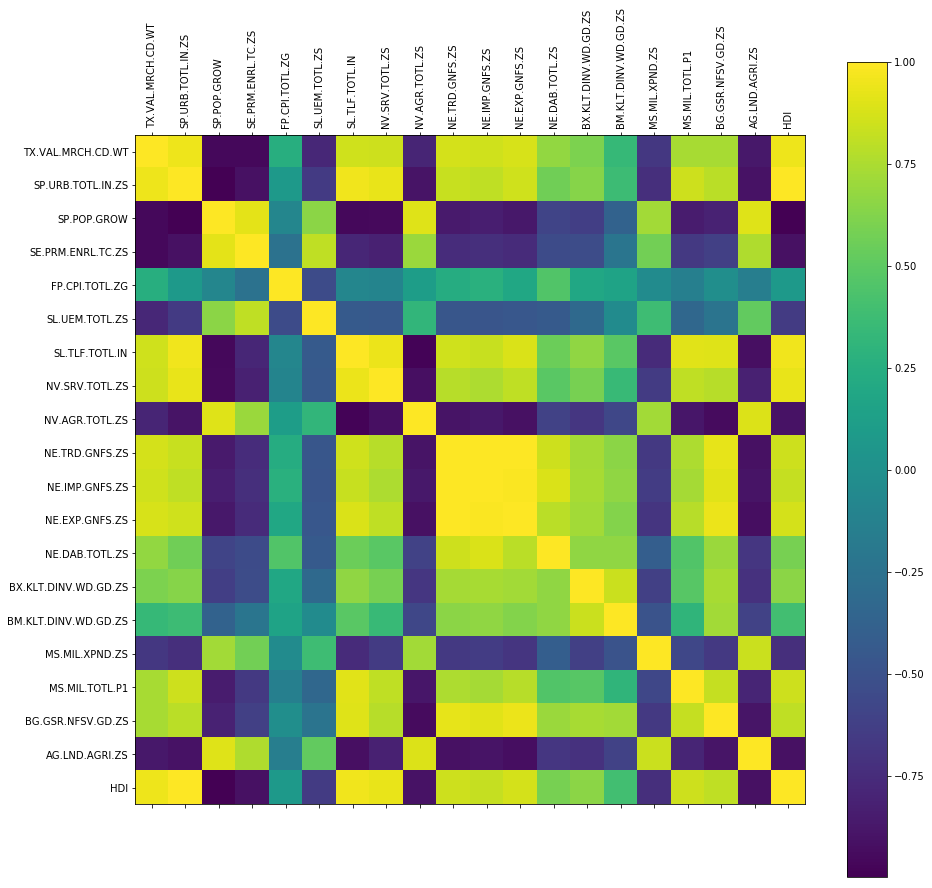

In [62]:
plot_corr(hdi_f)

In [63]:
hdi_flist = get_top_abs_correlations(hdi_f,'HDI',0.4)

In [64]:
hdi_india_final_df = pd.DataFrame(hdi_f, columns=hdi_flist)

In [65]:
hdi_country_final_df = []
for i in range(0,len(hdi_country_list)):
    hdi_country_final_df.append(pd.DataFrame(hdi_country_list[i], columns=hdi_flist))

In [66]:
hdi_x_val_list = []
hdi_y_val_list = []
for row in hdi_india_final_df.iterrows():
    index, data = row
    hdi_y_val_list.append(data[0])
    hdi_x_val_list.append(data[1:].tolist())

In [67]:
for i in range(0,len(hdi_country_final_df)):
    hdi_df_i = hdi_country_final_df[i]
    for row in hdi_df_i.iterrows():
        index, data = row
        hdi_y_val_list.append(data[0])
        hdi_x_val_list.append(data[1:].tolist())

In [68]:
hdi_x_val_array = np.asarray(hdi_x_val_list)
hdi_y_val_array = np.asarray(hdi_y_val_list)

In [69]:
hdi_x_y_values_db = {} 
hdi_x_y_values_db['x_val'] = hdi_x_val_array 
hdi_x_y_values_db['y_val'] = hdi_y_val_array 


# Its important to use binary mode 
hdi_dbfile = open('hdi_x_y_countries_pickle', 'ab') 
# source, destination 
pickle.dump(hdi_x_y_values_db, hdi_dbfile)                      
hdi_dbfile.close() 

In [70]:
hdi_forest_model = RandomForestRegressor(random_state=21)
hdi_train_X, hdi_test_X, hdi_train_y, hdi_test_y = train_test_split(hdi_x_val_array, hdi_y_val_array, test_size=0.25, random_state=21)
hdi_rmse= np.sqrt(np.mean(-cross_val_score(hdi_forest_model, hdi_train_X, hdi_train_y,cv=5,  scoring='neg_mean_squared_error')))
print("RMSE : %f" % (hdi_rmse))
hdi_r2_score1= np.mean(cross_val_score(hdi_forest_model, hdi_train_X, hdi_train_y,cv=5,  scoring='r2'))
print("R2 score: %s" % '{:.2}'.format(hdi_r2_score1))

RMSE : 0.012244
R2 score: 0.97


In [71]:
number_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': number_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [72]:
hdi_randomForestRegressor_dbfile = open('hdi_randomForestRegressor_pickle', 'rb')      
hdi_randomForestRegressor_db = pickle.load(hdi_randomForestRegressor_dbfile) 
#print x_y_values_db['x_val']
hdi_forest_model = hdi_randomForestRegressor_db['forest_model']
hdi_rf_random = hdi_randomForestRegressor_db['rf_random']
hdi_rf_grid = hdi_randomForestRegressor_db['rf_grid']
hdi_rf_cv_random = hdi_randomForestRegressor_db['rf_cv_random']
hdi_predictions = hdi_randomForestRegressor_db['predictions']
hdi_rmse3 = hdi_randomForestRegressor_db['rmse3']
hdi_r23 = hdi_randomForestRegressor_db['r23']
hdi_randomForestRegressor_dbfile.close() 

In [73]:
print(hdi_rf_random.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 110}


In [74]:
print(hdi_rf_grid.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 40}


In [75]:
print("RMSE : %f" % (hdi_rmse3))
print("R2 score: %s" % '{:.2}'.format(hdi_r23))

RMSE : 0.008203
R2 score: 0.98


In [76]:
hdi_errors = math.fabs(np.mean(hdi_predictions/hdi_test_y - 1))
hdi_mape = 100 * (hdi_errors)
hdi_accuracy = 100 - hdi_mape
#gdp_rf_cv_random.predict(test_X[2:4])
#test_y[2:4]

In [77]:
hdi_accuracy

99.9152805546158

Train IMR model 

In [78]:
imr_india = final_im_pd_df[['India']]
imr_india.index = imr_india.index.map(unicode) 
imr_india = imr_india.rename(index=str, columns={"India": "IMR"})
imr_f = pd.concat([india_df_final, imr_india], axis=1)

In [79]:
countries_list = developed_countries_list()
imr_country_list = []
for i in range(0,len(countries_df_final_list)):
    imr_country = final_im_pd_df[[countries_list[i]]]
    imr_country.index = imr_country.index.map(unicode)
    imr_country = imr_country.rename(index=str, columns={countries_list[i]: "IMR"})
    imr_country_list.append(pd.concat([countries_df_final_list[i], imr_country], axis=1))

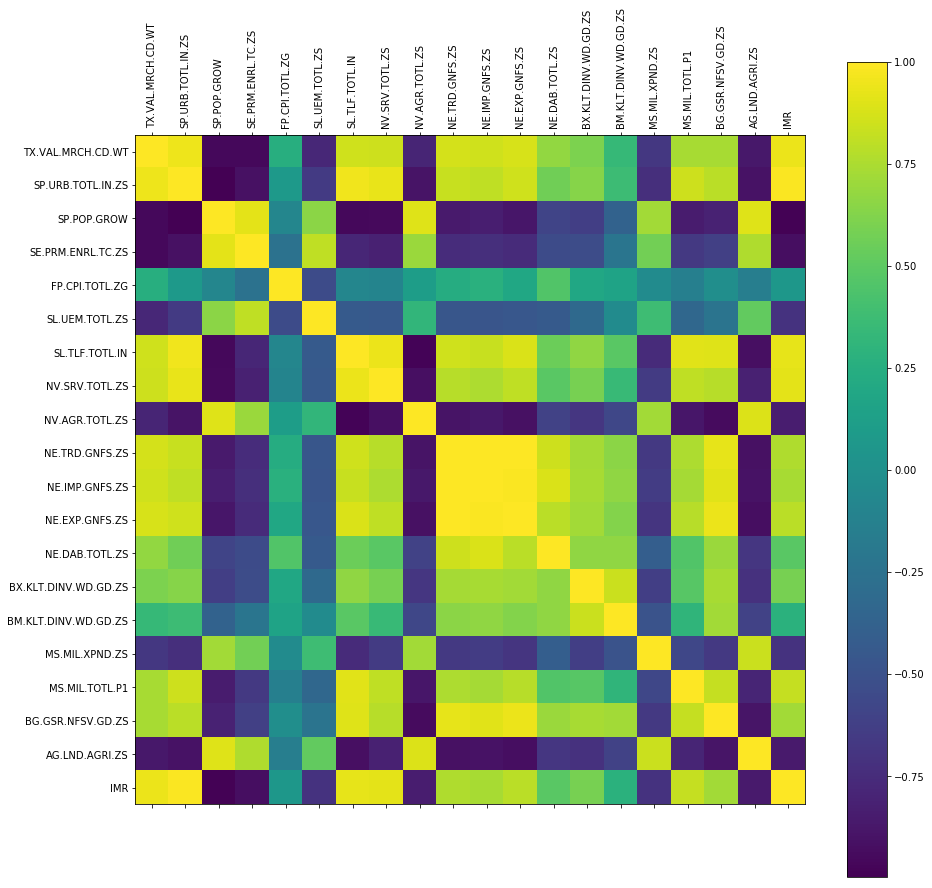

In [80]:
plot_corr(imr_f)

In [81]:
imr_flist = get_top_abs_correlations(imr_f,'IMR',0.4)

In [82]:
imr_india_final_df = pd.DataFrame(imr_f, columns=imr_flist)

In [83]:
imr_country_final_df = []
for i in range(0,len(imr_country_list)):
    imr_country_final_df.append(pd.DataFrame(imr_country_list[i], columns=imr_flist))

In [84]:
imr_x_val_list = []
imr_y_val_list = []
for row in imr_india_final_df.iterrows():
    index, data = row
    imr_y_val_list.append(data[0])
    imr_x_val_list.append(data[1:].tolist())

In [85]:
for i in range(0,len(imr_country_final_df)):
    imr_df_i = imr_country_final_df[i]
    for row in imr_df_i.iterrows():
        index, data = row
        imr_y_val_list.append(data[0])
        imr_x_val_list.append(data[1:].tolist())

In [86]:
imr_x_val_array = np.asarray(imr_x_val_list)
imr_y_val_array = np.asarray(imr_y_val_list)

In [87]:
imr_x_y_values_db = {} 
imr_x_y_values_db['x_val'] = imr_x_val_array 
imr_x_y_values_db['y_val'] = imr_y_val_array 


# Its important to use binary mode 
imr_dbfile = open('imr_x_y_countries_pickle', 'ab') 
# source, destination 
pickle.dump(imr_x_y_values_db, imr_dbfile)                      
imr_dbfile.close() 

In [88]:
imr_forest_model = RandomForestRegressor(random_state=21)
imr_train_X, imr_test_X, imr_train_y, imr_test_y = train_test_split(imr_x_val_array, imr_y_val_array, test_size=0.25, random_state=21)
imr_rmse= np.sqrt(np.mean(-cross_val_score(imr_forest_model, imr_train_X, imr_train_y,cv=5,  scoring='neg_mean_squared_error')))
print("RMSE : %f" % (imr_rmse))
imr_r2_score1= np.mean(cross_val_score(imr_forest_model, imr_train_X, imr_train_y,cv=5,  scoring='r2'))
print("R2 score: %s" % '{:.2}'.format(imr_r2_score1))

RMSE : 0.030921
R2 score: 0.9


In [89]:
number_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': number_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [90]:
imr_randomForestRegressor_dbfile = open('imr_randomForestRegressor_pickle', 'rb')      
imr_randomForestRegressor_db = pickle.load(imr_randomForestRegressor_dbfile) 
#print x_y_values_db['x_val']
imr_forest_model = imr_randomForestRegressor_db['forest_model']
imr_rf_random = imr_randomForestRegressor_db['rf_random']
imr_rf_grid = imr_randomForestRegressor_db['rf_grid']
imr_rf_cv_random = imr_randomForestRegressor_db['rf_cv_random']
imr_predictions = imr_randomForestRegressor_db['predictions']
imr_rmse3 = imr_randomForestRegressor_db['rmse3']
imr_r23 = imr_randomForestRegressor_db['r23']
imr_randomForestRegressor_dbfile.close() 

In [91]:
print(imr_rf_random.best_params_)

{'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': None}


In [92]:
print(imr_rf_grid.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 20}


In [93]:
print("RMSE : %f" % (imr_rmse3))
print("R2 score: %s" % '{:.2}'.format(imr_r23))

RMSE : 0.024873
R2 score: 0.94


In [94]:
imr_errors = math.fabs(np.mean(imr_predictions/imr_test_y - 1))
imr_mape = 100 * (imr_errors)
imr_accuracy = 100 - (imr_mape)

#gdp_rf_cv_random.predict(test_X[2:4])
#test_y[2:4]

In [95]:
imr_accuracy

99.66394063561928

Train LER model

In [96]:
ler_india = final_le_pd_df[['India']]
ler_india.index = ler_india.index.map(unicode) 
ler_india = ler_india.rename(index=str, columns={"India": "LER"})
ler_f = pd.concat([india_df_final, ler_india], axis=1)

In [97]:
countries_list = developed_countries_list()
ler_country_list = []
for i in range(0,len(countries_df_final_list)):
    ler_country = final_le_pd_df[[countries_list[i]]]
    ler_country.index = ler_country.index.map(unicode)
    ler_country = ler_country.rename(index=str, columns={countries_list[i]: "LER"})
    ler_country_list.append(pd.concat([countries_df_final_list[i], ler_country], axis=1))

In [98]:
ler_f

,TX.VAL.MRCH.CD.WT,SP.URB.TOTL.IN.ZS,SP.POP.GROW,SE.PRM.ENRL.TC.ZS,FP.CPI.TOTL.ZG,SL.UEM.TOTL.ZS,SL.TLF.TOTL.IN,NV.SRV.TOTL.ZS,NV.AGR.TOTL.ZS,NE.TRD.GNFS.ZS,NE.IMP.GNFS.ZS,NE.EXP.GNFS.ZS,NE.DAB.TOTL.ZS,BX.KLT.DINV.WD.GD.ZS,BM.KLT.DINV.WD.GD.ZS,MS.MIL.XPND.ZS,MS.MIL.TOTL.P1,BG.GSR.NFSV.GD.ZS,AG.LND.AGRI.ZS,LER
1995,306300.0,26.607,1.921399,41.125675,10.224888,3.716,36822.1327,36.385692,24.738004,23.115306,12.157415,10.957891,101.199524,0.603030,0.032967,10.503252,2149.500,4.794279,60.858875,60.408
1996,331050.0,26.817,1.898649,40.844256,8.977149,3.814,37526.4721,36.650735,25.709218,22.167187,11.672915,10.494272,101.178643,0.625827,0.061736,10.327281,2223.000,4.748906,60.739139,60.877
1997,350080.0,27.028,1.873466,40.562837,7.164254,4.060,38254.7455,38.173915,24.625224,22.864578,12.061547,10.803030,101.258517,0.871838,0.027520,10.677902,2233.000,5.252803,60.870984,61.327
1998,334370.0,27.240,1.844585,40.281419,13.230841,4.064,39004.1620,39.197190,24.659073,23.956484,12.822259,11.134225,101.688034,0.633740,0.011448,10.659508,2265.000,6.309619,60.834995,61.761
1999,356670.0,27.453,1.810832,40.000000,4.669821,4.063,39771.3183,40.694362,23.253236,25.084771,13.512395,11.572376,101.940019,0.479035,0.017530,11.640564,2263.000,7.020163,60.884437,62.179
2000,423790.0,27.667,1.773546,39.999989,4.009434,4.317,40552.1019,41.269001,21.857368,27.192345,14.058565,13.133781,100.924784,0.775558,0.110253,11.503057,2372.000,7.762265,60.868966,62.582
2001,433610.0,27.918,1.734729,40.149990,3.684807,4.326,41700.3387,42.571818,21.869048,26.274845,13.584531,12.690313,100.894218,1.070660,0.220085,10.523952,2352.700,7.815995,60.704832,62.977
2002,492500.0,28.244,1.696185,40.662960,4.392200,4.432,42886.2880,43.538430,19.761288,29.828331,15.414091,14.414240,100.999850,1.025248,0.248209,9.879556,2387.700,7.974779,60.729385,63.368
2003,589629.0,28.572,1.658100,41.329880,3.805866,4.308,44104.9645,43.669642,19.805700,30.923744,15.818792,15.104951,100.713841,0.614081,0.206448,9.100118,2414.700,8.135462,60.624783,63.759
2004,766486.0,28.903,1.621038,40.557973,3.767238,4.369,45348.9620,42.845225,18.019456,37.910265,19.863519,18.046746,101.816772,0.775952,0.262554,10.117429,2617.000,10.510223,60.667162,64.154


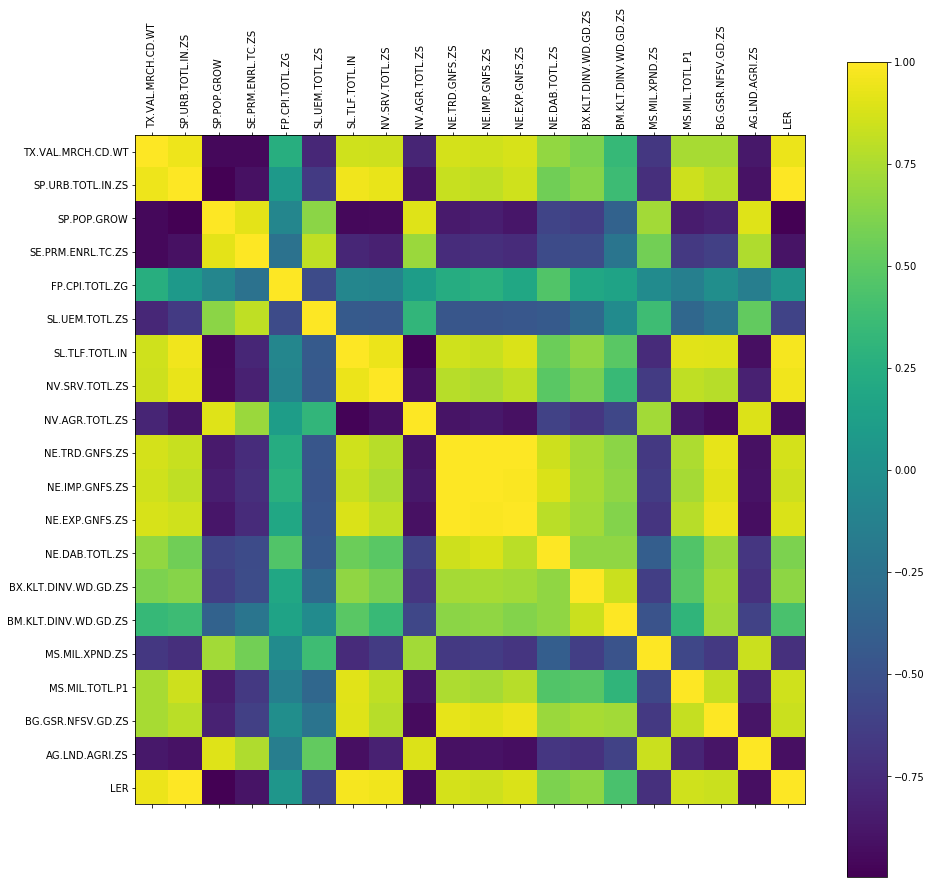

In [99]:
plot_corr(ler_f)

In [100]:
ler_flist = get_top_abs_correlations(ler_f,'LER',0.4)

In [101]:
ler_india_final_df = pd.DataFrame(ler_f, columns=ler_flist)

In [102]:
ler_country_final_df = []
for i in range(0,len(ler_country_list)):
    ler_country_final_df.append(pd.DataFrame(ler_country_list[i], columns=ler_flist))

In [103]:
ler_x_val_list = []
ler_y_val_list = []
for row in ler_india_final_df.iterrows():
    index, data = row
    ler_y_val_list.append(data[0])
    ler_x_val_list.append(data[1:].tolist())

In [104]:
for i in range(0,len(ler_country_final_df)):
    ler_df_i = ler_country_final_df[i]
    for row in ler_df_i.iterrows():
        index, data = row
        ler_y_val_list.append(data[0])
        ler_x_val_list.append(data[1:].tolist())

In [105]:
ler_x_val_array = np.asarray(ler_x_val_list)
ler_y_val_array = np.asarray(ler_y_val_list)

In [106]:
ler_x_y_values_db = {} 
ler_x_y_values_db['x_val'] = ler_x_val_array 
ler_x_y_values_db['y_val'] = ler_y_val_array 


# Its important to use binary mode 
ler_dbfile = open('ler_x_y_countries_pickle', 'ab') 
# source, destination 
pickle.dump(ler_x_y_values_db, ler_dbfile)                      
ler_dbfile.close() 

In [107]:
ler_forest_model = RandomForestRegressor(random_state=21)
ler_train_X, ler_test_X, ler_train_y, ler_test_y = train_test_split(ler_x_val_array, ler_y_val_array, test_size=0.25, random_state=21)
ler_rmse= np.sqrt(np.mean(-cross_val_score(ler_forest_model, ler_train_X, ler_train_y,cv=5,  scoring='neg_mean_squared_error')))
print("RMSE : %f" % (ler_rmse))
ler_r2_score1= np.mean(cross_val_score(ler_forest_model, ler_train_X, ler_train_y,cv=5,  scoring='r2'))
print("R2 score: %s" % '{:.2}'.format(ler_r2_score1))

RMSE : 0.788305
R2 score: 0.95


In [108]:
number_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': number_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [109]:
ler_randomForestRegressor_dbfile = open('ler_randomForestRegressor_pickle', 'rb')      
ler_randomForestRegressor_db = pickle.load(ler_randomForestRegressor_dbfile) 
#print x_y_values_db['x_val']
ler_forest_model = ler_randomForestRegressor_db['forest_model']
ler_rf_random = ler_randomForestRegressor_db['rf_random']
ler_rf_grid = ler_randomForestRegressor_db['rf_grid']
ler_rf_cv_random = ler_randomForestRegressor_db['rf_cv_random']
ler_predictions = ler_randomForestRegressor_db['predictions']
ler_rmse3 = ler_randomForestRegressor_db['rmse3']
ler_r23 = ler_randomForestRegressor_db['r23']
ler_randomForestRegressor_dbfile.close() 

In [110]:
print(ler_rf_random.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 40}


In [111]:
print(ler_rf_grid.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 800, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 20}


In [112]:
print("RMSE : %f" % (ler_rmse3))
print("R2 score: %s" % '{:.2}'.format(ler_r23))

RMSE : 0.538204
R2 score: 0.97


In [113]:
ler_errors = math.fabs(np.mean(ler_predictions/ler_test_y - 1))
ler_mape = 100 * (ler_errors)
ler_accuracy = 100 - (ler_mape)
#gdp_rf_cv_random.predict(test_X[2:4])
#test_y[2:4]

In [114]:
ler_accuracy

99.9619502754818

# PHASE 4

In [115]:
def get_timeline_avg_slope_array(india_df_for_pred):
    timeline_avg_slope_list = []
    for col in india_df_for_pred.columns:
        sum = 0
        limit = len(india_df_for_pred[col])-1
        for i in range(0,limit):
            val = india_df_for_pred[col]
            sum += (val[i+1] - val[i])
        sum /= limit
        timeline_avg_slope_list.append(sum)
    timeline_avg_slope_array = np.asarray(timeline_avg_slope_list)
    return timeline_avg_slope_array

In [116]:
def get_latest_x_val_array(india_df_for_pred):
    latest_x_val_list = []
    last_index = int(india_df_for_pred.index[len(india_df_for_pred.index)-1])
    for col in india_df_for_pred.columns:
        latest_x_val_list.append(india_df_for_pred[col][len(india_df_for_pred[col])-1])
    latest_x_val_array = np.asarray(latest_x_val_list)
    return latest_x_val_array,last_index

In [117]:
india_df_for_pred1 = gdp_india_final_df.drop(['GDP.PC'],axis=1)
india_df_for_pred2 = hdi_india_final_df.drop(['HDI'],axis=1)
india_df_for_pred3 = ler_india_final_df.drop(['LER'],axis=1)
india_df_for_pred4 = imr_india_final_df.drop(['IMR'],axis=1)

In [118]:
india_gdp_df_for_pred = final_gdp_perc_pd_df[['India']]
india_hdi_df_for_pred = final_hdi_pd_df[['India']]
india_imr_df_for_pred = final_im_pd_df[['India']]
india_ler_df_for_pred = final_le_pd_df[['India']]

In [119]:
timeline_avg_slope_array_gdp = get_timeline_avg_slope_array(india_df_for_pred1)
timeline_avg_slope_array_hdi = get_timeline_avg_slope_array(india_df_for_pred2)
timeline_avg_slope_array_ler = get_timeline_avg_slope_array(india_df_for_pred3)
timeline_avg_slope_array_imr = get_timeline_avg_slope_array(india_df_for_pred4)

In [120]:
latest_x_val_array_gdp,last_index_gdp = get_latest_x_val_array(india_df_for_pred1)
latest_x_val_array_hdi,last_index_hdi = get_latest_x_val_array(india_df_for_pred2)
latest_x_val_array_ler,last_index_ler = get_latest_x_val_array(india_df_for_pred3)
latest_x_val_array_imr,last_index_imr = get_latest_x_val_array(india_df_for_pred4)

In [142]:
run_times = 1
for i in range(0,run_times):    
    
    new_latest_x_val_array_gdp = latest_x_val_array_gdp + timeline_avg_slope_array_gdp
    india_df_for_pred1.loc[str(last_index_gdp+1)] = new_latest_x_val_array_gdp
    temp_gdp_df = pd.DataFrame(india_df_for_pred1, columns=gdp_flist[1:len(gdp_flist)])
    input_x_gdp = np.asarray(temp_gdp_df.values[-1].tolist())
    input_x_gdp = np.reshape(input_x_gdp, (-1, temp_gdp_df.shape[1]))
    gdp_pred = gdp_rf_cv_random.predict(input_x_gdp)
    india_gdp_df_for_pred.loc[str(last_index_gdp+1)] = gdp_pred
    
    new_latest_x_val_array_hdi = latest_x_val_array_hdi + timeline_avg_slope_array_hdi
    india_df_for_pred2.loc[str(last_index_hdi+1)] = new_latest_x_val_array_hdi
    temp_hdi_df = pd.DataFrame(india_df_for_pred2, columns=hdi_flist[1:len(hdi_flist)])
    input_x_hdi = np.asarray(temp_hdi_df.values[-1].tolist())
    input_x_hdi = np.reshape(input_x_hdi, (-1, temp_hdi_df.shape[1]))
    hdi_pred = hdi_rf_cv_random.predict(input_x_hdi)
    india_hdi_df_for_pred.loc[str(last_index_hdi+1)] = hdi_pred
    
    new_latest_x_val_array_ler = latest_x_val_array_ler + timeline_avg_slope_array_ler
    india_df_for_pred3.loc[str(last_index_ler+1)] = new_latest_x_val_array_ler
    temp_ler_df = pd.DataFrame(india_df_for_pred3, columns=ler_flist[1:len(ler_flist)])
    input_x_ler = np.asarray(temp_ler_df.values[-1].tolist())
    input_x_ler = np.reshape(input_x_ler, (-1, temp_ler_df.shape[1]))
    ler_pred = ler_rf_cv_random.predict(input_x_ler)
    india_ler_df_for_pred.loc[str(last_index_ler+1)] = ler_pred
    
    new_latest_x_val_array_imr = latest_x_val_array_imr + timeline_avg_slope_array_imr
    india_df_for_pred4.loc[str(last_index_imr+1)] = new_latest_x_val_array_imr
    temp_imr_df = pd.DataFrame(india_df_for_pred4, columns=imr_flist[1:len(imr_flist)])
    input_x_imr = np.asarray(temp_imr_df.values[-1].tolist())
    input_x_imr = np.reshape(input_x_imr, (-1, temp_imr_df.shape[1]))
    imr_pred = imr_rf_cv_random.predict(input_x_imr)
    india_imr_df_for_pred.loc[str(last_index_imr+1)] = imr_pred
    
    latest_x_val_array_gdp = new_latest_x_val_array_gdp
    latest_x_val_array_hdi = new_latest_x_val_array_hdi
    latest_x_val_array_ler = new_latest_x_val_array_ler
    latest_x_val_array_imr = new_latest_x_val_array_imr
    
    last_index_gdp += 1
    last_index_hdi += 1
    last_index_ler += 1
    last_index_imr += 1

/Users/siddhant/miniconda/envs/dataScience_env/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/siddhant/miniconda/envs/dataScience_env/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/siddhant/miniconda/envs/dataScience_env/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/

In [145]:
india_gdp_df_for_pred

,India
1995,370.101372
1996,396.014594
1997,411.387420
1998,409.194510
1999,437.586119
2000,438.864821
2001,447.013438
2002,466.200848
2003,541.135316
2004,621.318507
